# MIE1622 - COMPUTATIONAL FINANCE AND RISK MANAGEMENT 
# ASSIGNMENT 2
# GOKUL RAVI - 1008312309

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math

In [2]:
# Cplex installation on Google Colab:
#!pip install cplex

In [3]:
# Cyipopt installation on Google Colab:
#!apt install build-essential pkg-config python3-pip python3-dev cython3 python3-numpy coinor-libipopt1v5 coinor-libipopt-dev

#!pip install cyipopt

In [4]:
import matplotlib.pyplot as plt
from scipy import sparse
import cplex
import cyipopt as ipopt

In [5]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

In [6]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    total_val = cash_init + np.dot(cur_prices,x_init) 
    equal_val = np.ones((20)) * (total_val / 20) # equally allocate money for each asset
    x_optimal = np.floor(equal_val / cur_prices)
    tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init)) #calculating transaction cost
    cash_optimal = total_val - np.dot(cur_prices,x_optimal) - tran_cost
    return x_optimal, cash_optimal

In [7]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    
    cpx = cplex.Cplex() #cplex object creation
    cpx.objective.set_sense(cpx.objective.sense.minimize) #objective set to minimize
    total_val = cash_init + np.dot(cur_prices,x_init) 
    n_stocks = 20
    c = np.zeros((20))
    lb = np.zeros((20)) #lower bound
    ub = np.ones((20)) #upper bound
    
    A = []
    for i in range(n_stocks):
        A.append([[0,1],[1,0]])
    var_names = ['weight_%s'% i for i in range(1,n_stocks+1)] #variable names of weights
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EG') #constraint for sum of weights is 1
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)

    qmat = [[list(range(n_stocks)),list(2*Q[i,:])] for i in range(n_stocks)] # quadratic part of objective function
    cpx.objective.set_quadratic(qmat) #Objective
    cpx.set_results_stream(None)
    cpx.solve()
    global w_minVar
    w_minVar = np.array(cpx.solution.get_values()) 
    
    money_alloc = w_minVar * total_val   #allocation from total value
    x_optimal = np.floor(money_alloc / cur_prices)  #share calculation
    
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = total_val - np.dot(cur_prices,x_optimal) - tran_cost
    
    return x_optimal, cash_optimal

In [8]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    cpx = cplex.Cplex() #cplex object creation
    cpx.objective.set_sense(cpx.objective.sense.minimize) #objective set to minimize
    
    total_val = cash_init + np.dot(cur_prices,x_init) 
    n_stocks = 21 #considering risk-free return as a stock too
    daily_riskfree = r_rf/252 #on an average 252 trading days
    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q1 = np.append(Q1,np.zeros((1,21)),axis=0)
    
    change = np.ones(20) * (mu - daily_riskfree)
    
    A=[]
    for i in range(n_stocks-1):
        A.append([[0,1],[change[i],1.0]])
    A.append([[0,1],[0,-1.0]])
    

    c = [0]*n_stocks
    lb = [0]*n_stocks #lower bound
    ub = [np.inf]*n_stocks #upper bound
    
    var_names = ['sharpe_weight_%s'% i for i in range(1,n_stocks+1)] #variable names of weights
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE') #constraint for sum of weights is 1
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)
    
    qmat = [[list(range(n_stocks)),list(2*Q1[i,:])] for i in range(n_stocks)]  #quadratic part of objective function

    cpx.objective.set_quadratic(qmat)
    cpx.set_results_stream(None)
    cpx.solve()
    
    global w_maxSharpe
    if cpx.solution.get_status_string()== 'infeasible':
            x_optimal = x_init
            cash_optimal = cash_init
            w_maxSharpe = (x_init*cur_prices)/portfolio_value
            
    else:
        result = np.array(cpx.solution.get_values())
        w_maxSharpe = result[0:20]/result[20]

    money_alloc = w_maxSharpe * total_val    #allocation from total value
    x_optimal = np.floor(money_alloc / cur_prices)  #share calculation

    tran_cost = sum(cur_prices * abs(x_optimal-x_init) * 0.005)
    cash_optimal = total_val - np.dot(cur_prices,x_optimal) - tran_cost
        
    return x_optimal, cash_optimal

In [9]:
# Objective function, constraints, gradient of objective function, and jacobian of constrants for the ERC problem
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(20):
            for j in range(i,20):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval
    
    def gradient(self, x):
      # Compute the exact gradient 
        grad_exact = np.zeros_like(x)
        y = x * np.dot(Q, x)
        for i in range(20):
            for j in range(i, 20):
                g = (y[i] - y[j]) * ((Q[i].dot(x) + Q[i,i] * x[i]) - (Q[i,j] * x[i]))
                grad_exact[i] = grad_exact[i] + g
            grad_exact[i] = 4 * grad_exact[i]
        #Validating gradient
        h = 1e-6
        # Initialize an array to store the approximate gradients
        gradient_approx = np.zeros_like(x)

        # Compute approximate gradients using finite differences
        for i in range(len(x)):
            # Perturb the i-th element of x
            x_perturbed = x.copy()
            x_perturbed[i] += h

            # Compute objective function values for both x and perturbed x
            fval = self.objective(x)
            fval_perturbed = self.objective(x_perturbed)

            # Approximate the gradient using finite differences
            gradient_approx[i] = (fval_perturbed - fval) / h

        # Compare the exact gradient with the approximate gradient
        diff = np.linalg.norm(grad_exact - gradient_approx)
        if diff > 1e-4:
            print("Gradient validation failed. Difference:", diff)  
        return grad_exact

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * 20
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * 20])

In [10]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    total_value = cur_prices.dot(x_init) + cash_init
    
    n = 20
    w0 = [1/n] * n

    lb = [0] * n
    ub = [1] * n
    cl = [1]
    cu = [1]
    
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    global w_erc
    w_erc, info = nlp.solve(w0)
    
    std_ERC= np.sqrt(np.dot(w_erc, np.dot(Q, w_erc)))
    RC_ERC = (w_erc* np.dot(Q, w_erc)) / std_ERC
    
    money_allocation = w_erc * total_value
    x_optimal = np.floor(money_allocation / cur_prices)  #get integer shares
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = total_value - np.dot(cur_prices,x_optimal) - tran_cost

    return x_optimal, cash_optimal

In [11]:
def strat_lever_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    total_val = cash_init + np.dot(cur_prices,x_init) 
    borrow_value = init_value 
    
    if period == 1:
        total_val = total_val + borrow_value   

    n_stocks = 21 #considering risk-free return as a stock too
    daily_riskfree = r_rf/252 #on an average 252 trading days
    cpx = cplex.Cplex() #cplex object creation
    cpx.objective.set_sense(cpx.objective.sense.minimize) #objective set to minimize
    
    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q1 = np.append(Q1,np.zeros((1,21)),axis=0)
    
    change = np.ones(20) * (mu - daily_riskfree)
    
    A=[]
    for i in range(n_stocks-1):
        A.append([[0,1],[change[i],1.0]])
    A.append([[0,1],[0,-1.0]])
    

    c = [0]*n_stocks
    lb = [0]*n_stocks #lower bound
    ub = [np.inf]*n_stocks #upper bound
    
    var_names = ['sharpe_weight_%s'% i for i in range(1,n_stocks+1)] #variable names of weights
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE') #constraint for sum of weights is 1
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)
    
    qmat = [[list(range(n_stocks)),list(2*Q1[i,:])] for i in range(n_stocks)]  #quadratic part of objective function

    cpx.objective.set_quadratic(qmat)
    cpx.set_results_stream(None)
    cpx.solve()
    
    if cpx.solution.get_status_string()== 'infeasible':
            x_optimal = x_init
            cash_optimal = cash_init
            w_maxSharpe = (x_init*cur_prices)/total_val
            
    else:
        result = np.array(cpx.solution.get_values())
        w_maxSharpe = result[0:20]/result[20]
    

    money_alloc = w_maxSharpe * total_val    #allocation from total value
    x_optimal = np.floor(money_alloc / cur_prices)  #share calculation

    tran_cost = sum(cur_prices * abs(x_optimal-x_init) * 0.005)
    cash_optimal = total_val - np.dot(cur_prices,x_optimal) - tran_cost
        
    return x_optimal, cash_optimal

In [12]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    
    n = 20
    total_val = cur_prices.dot(x_init) + cash_init
    
    w0 = [1/n]*n
    ret_init = np.dot(mu, w0)
    var_init = np.dot(w0, np.dot(Q, w0))
    
    var_matr = np.diag(np.diag(Q))
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    rob_bnd = rob_init

    daily_r_rf = r_rf/252
    
    Portf_Retn = daily_r_rf
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
        
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    if cpx.solution.get_status_string()== 'infeasible':
            x_optimal = x_init
            cash_optimal = cash_init
            
    else:
        w_rMV = np.array(cpx.solution.get_values())
        w_rMV[w_rMV<1e-6] = 0 #round near-zero
        w_rMV = w_rMV / np.sum(w_rMV)

        money_allocation = w_rMV * total_val
        x_optimal = np.floor(money_allocation / cur_prices)  #get integer shares
        tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
        cash_optimal = total_val - np.dot(cur_prices,x_optimal) - tran_cost
    
    return x_optimal, cash_optimal

## Reasons for Selecting Target Expected Return and Target Risk Estimation Error in RMVO.

Target Expected Return - Daily Risk-Free Return
- Using the Risk-Free Return as the target provides us a consideration of the potential returns that would be missed if we had invested in Risk-Free asset.
- Aligning the daily risk-free return with the expected portfolio return ensures consistency in the time horizon.
- Using the expected portfolio return as the daily risk-free return simplifies the optimization process and makes it more practical for implementation

Target Risk Estimation Error - Return of Equally Weighted Portfolio
- The 1/n portfolio's equal weighting of assets creates high diversification, reducing risk and making it a popular benchmark for assessing portfolio performance.

# FOR 2020 & 2021

In [13]:
# Input file
input_file_prices = 'Daily_closing_prices2020_2021.csv'

In [14]:
# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [15]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])   # for 2020-2021 csv

#day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])   # for 2008-2009 csv
#day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])   # for 2022 csv

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_max_Sharpe', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio' ]
#N_strat = 6 # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_max_Sharpe, strat_robust_optim]
#fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe,strat_equal_risk_contr, strat_robust_optim]


portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
interest = np.full((1,N_periods), init_value * (r_rf/6), dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period

   # Depending on what data/csv (i.e time period) uncomment code
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]


   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
      if strategy == 5:
        cash[strategy, period-1] = cash[strategy, period-1] - interest[0,period-1]

      
      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if cash[strategy, period-1] < 0:
        if strategy==5 and cash[5,0]<0:
            portfolio_value = (curr_cash + np.dot(cur_prices,curr_positions))*2
        else:
            portfolio_value = curr_cash + np.dot(cur_prices,curr_positions)
            
        weight = x[strategy, period-1]/sum(x[strategy, period-1])
        non_cash = weight * abs(cash[strategy, period-1])
        x[strategy, period-1] = x[strategy, period-1] - np.ceil(non_cash/cur_prices)
        tran_cost_1 = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
        
        if strategy==5:
            cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - tran_cost_1 - interest[0,period-1]
        else:
            cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - tran_cost_1
            
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      if strategy ==5:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
    
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992758.37, value end = $ 916243.56
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.17, value end = $ 922092.60


C:\ProgramData\Anaconda3\lib\site-packages\cyipopt\utils.py:43: FutureWarning: The method named 'addOption' in class 'Problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)


  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991320.61, value end = $ 899715.70
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 980942.67, value end = $ 844916.65
  Strategy "Robust Optimization Portfolio", value begin = $ 992214.71, value end = $ 917840.24

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 955991.26, value end = $ 851553.64
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962076.86, value end = $ 1017235.47
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 939015.71, value end = $ 852893.25
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 920793.97, value end = $ 1030921.34
  Strategy "Robust Optimization Portfolio", value begin = $ 963171.85, value end = $ 94

## Plot Results

### PLOT FOR DAILY VALUE OF PORTFOLIOS

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

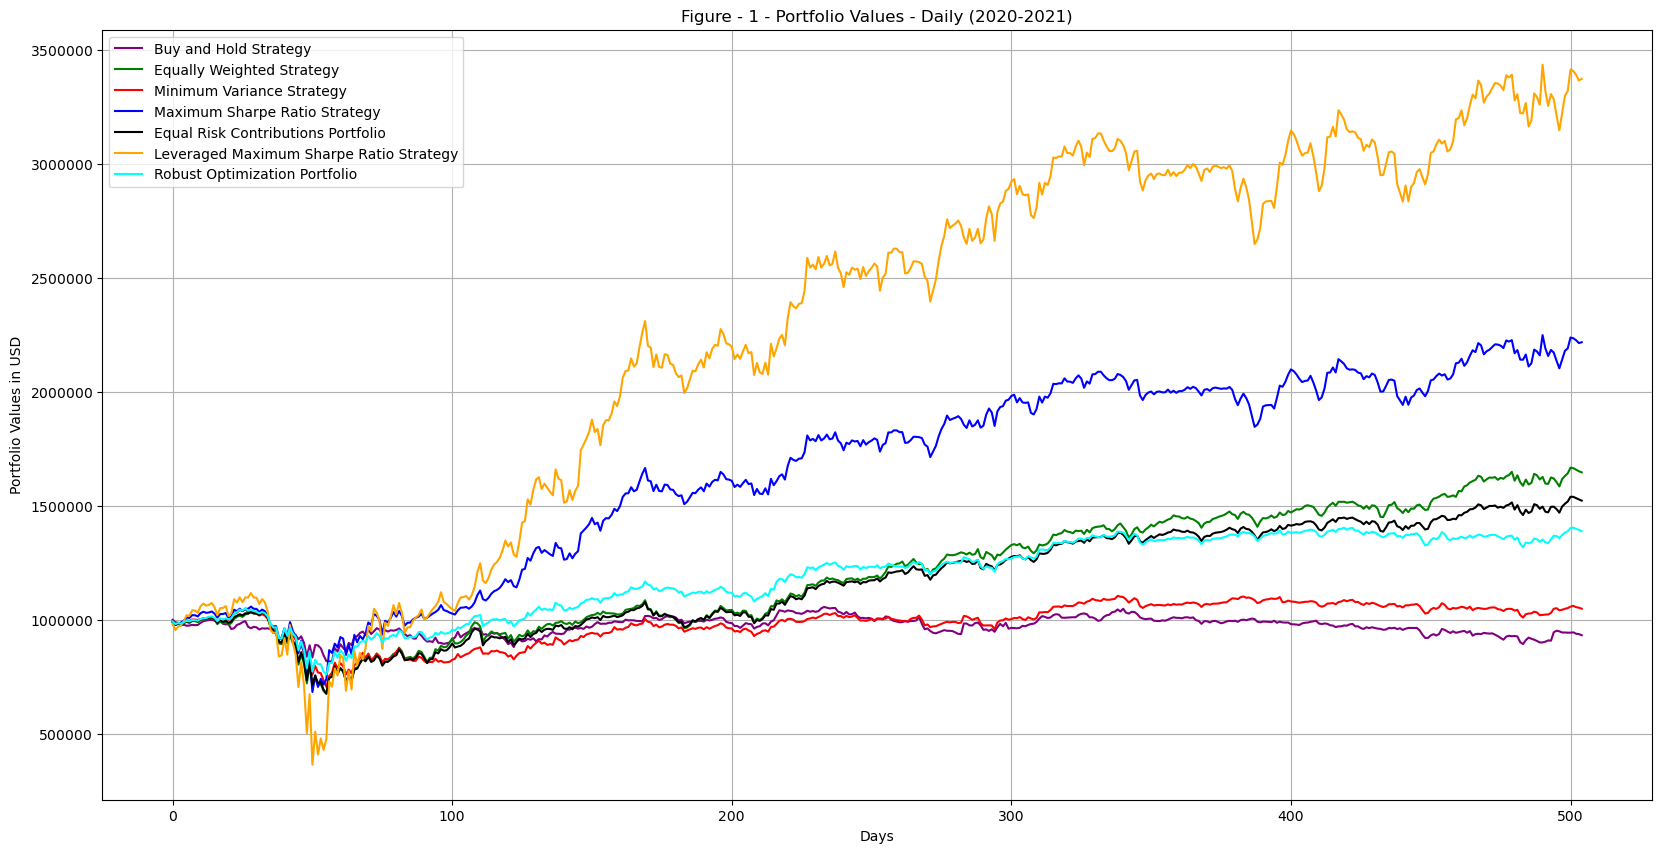

In [17]:
plt.figure(figsize=(20,10))
plt.plot(portf_value[0],label='Buy and Hold Strategy',color='purple')
plt.plot(portf_value[1],label='Equally Weighted Strategy',color='green')
plt.plot(portf_value[2],label='Minimum Variance Strategy',color='red')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio Strategy',color='blue')
plt.plot(portf_value[4],label='Equal Risk Contributions Portfolio',color='black')
plt.plot(portf_value[5],label='Leveraged Maximum Sharpe Ratio Strategy',color='orange')
plt.plot(portf_value[6],label='Robust Optimization Portfolio',color='cyan')
plt.legend()


formatter = ticker.ScalarFormatter(useMathText=True)
plt.gca().yaxis.set_major_formatter(formatter)
formatter.set_scientific(False)


plt.title('Figure - 1 - Portfolio Values - Daily (2020-2021)')
plt.xlabel('Days')
plt.ylabel('Portfolio Values in USD')
plt.grid(True)
plt.show()

### PLOT FOR MAXIMUM DRAWDOWN OF PORTFOLIO STRATEGIES

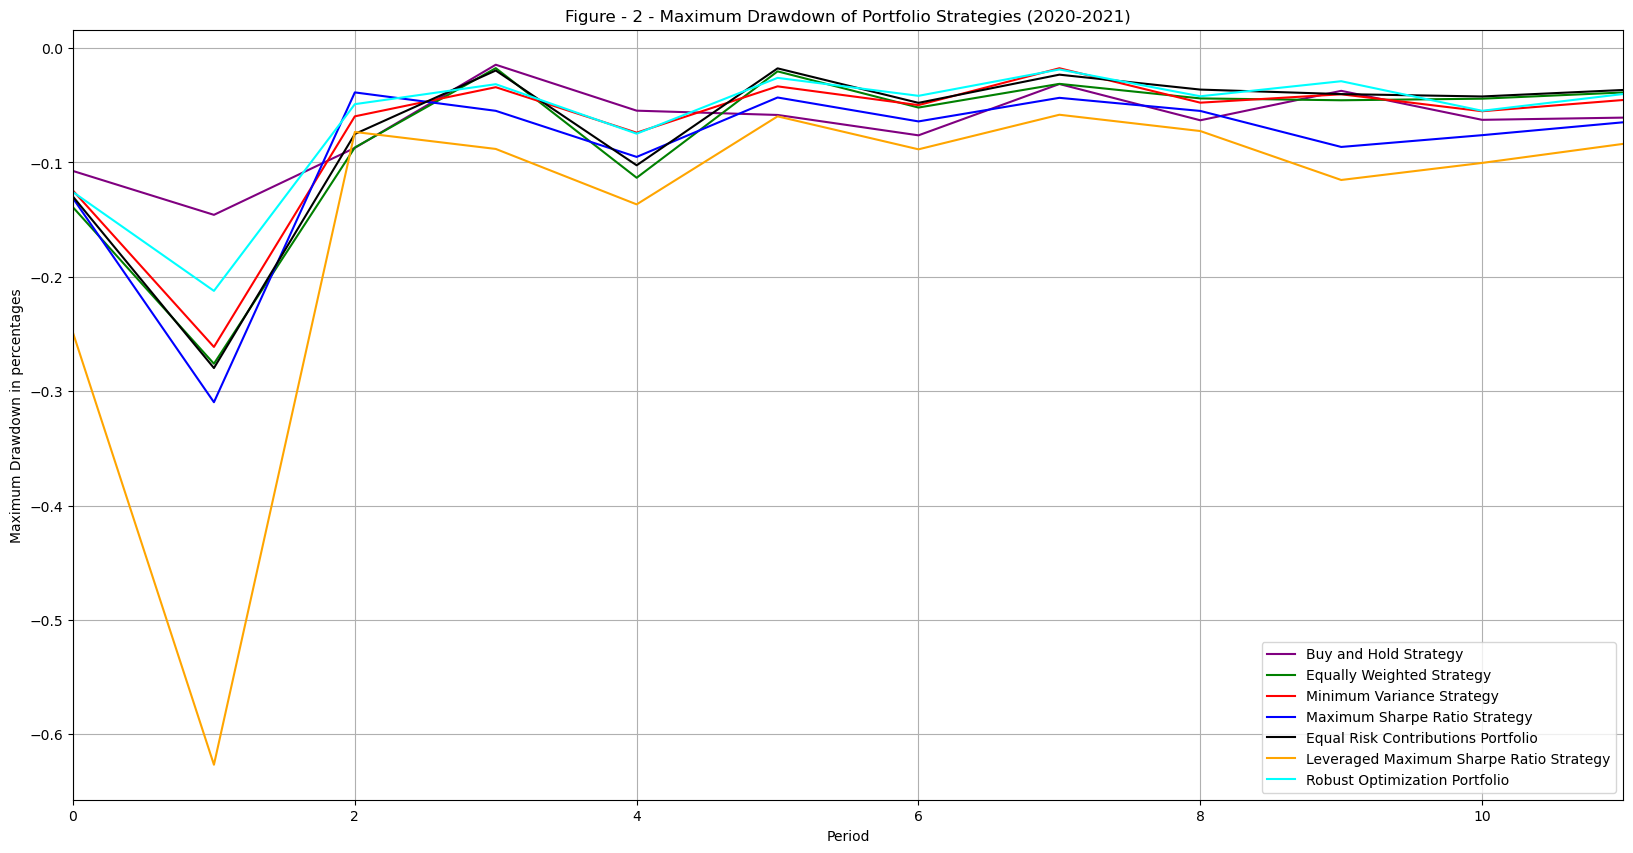

In [18]:
max_drawdowns_periods = []
for portf in portf_value:
    max_drawdowns = []
    for period in range(1, N_periods+1):
            # Depending on what data/csv (i.e time period) uncomment code
        if dates_array[0, 0] == 20:
           cur_year  = 20 + math.floor(period/7)
        else:
           cur_year  = 2020 + math.floor(period/7)

        cur_month = 2*((period-1)%6) + 1
        day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
        day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
        period_portf = portf[day_ind_start:day_ind_end+1]
        #period_portf = [portf[day_ind_start], portf[day_ind_end]]
        if len(period_portf) > 0:
            rolling_max = np.maximum.accumulate(period_portf)
            drawdown = (period_portf - rolling_max) / rolling_max
            max_drawdowns.append(np.min(drawdown))
    max_drawdowns_periods.append(max_drawdowns)
# Plot maximum drawdown for each strategy
plt.figure(figsize=(20,10))
plt.plot(max_drawdowns_periods[0],label='Buy and Hold Strategy',color='purple')
plt.plot(max_drawdowns_periods[1],label='Equally Weighted Strategy',color='green')
plt.plot(max_drawdowns_periods[2],label='Minimum Variance Strategy',color='red')
plt.plot(max_drawdowns_periods[3],label='Maximum Sharpe Ratio Strategy',color='blue')
plt.plot(max_drawdowns_periods[4],label='Equal Risk Contributions Portfolio',color='black')
plt.plot(max_drawdowns_periods[5],label='Leveraged Maximum Sharpe Ratio Strategy',color='orange')
plt.plot(max_drawdowns_periods[6],label='Robust Optimization Portfolio',color='cyan')

plt.title('Figure - 2 - Maximum Drawdown of Portfolio Strategies (2020-2021)')
plt.xlabel('Period')
plt.ylabel('Maximum Drawdown in percentages')
plt.xlim(0, 11)  # Set y-axis limits from 0 to 1
plt.legend()
plt.grid(True)
plt.show()

### Dynamic Changes in Robust MVO Portfolio

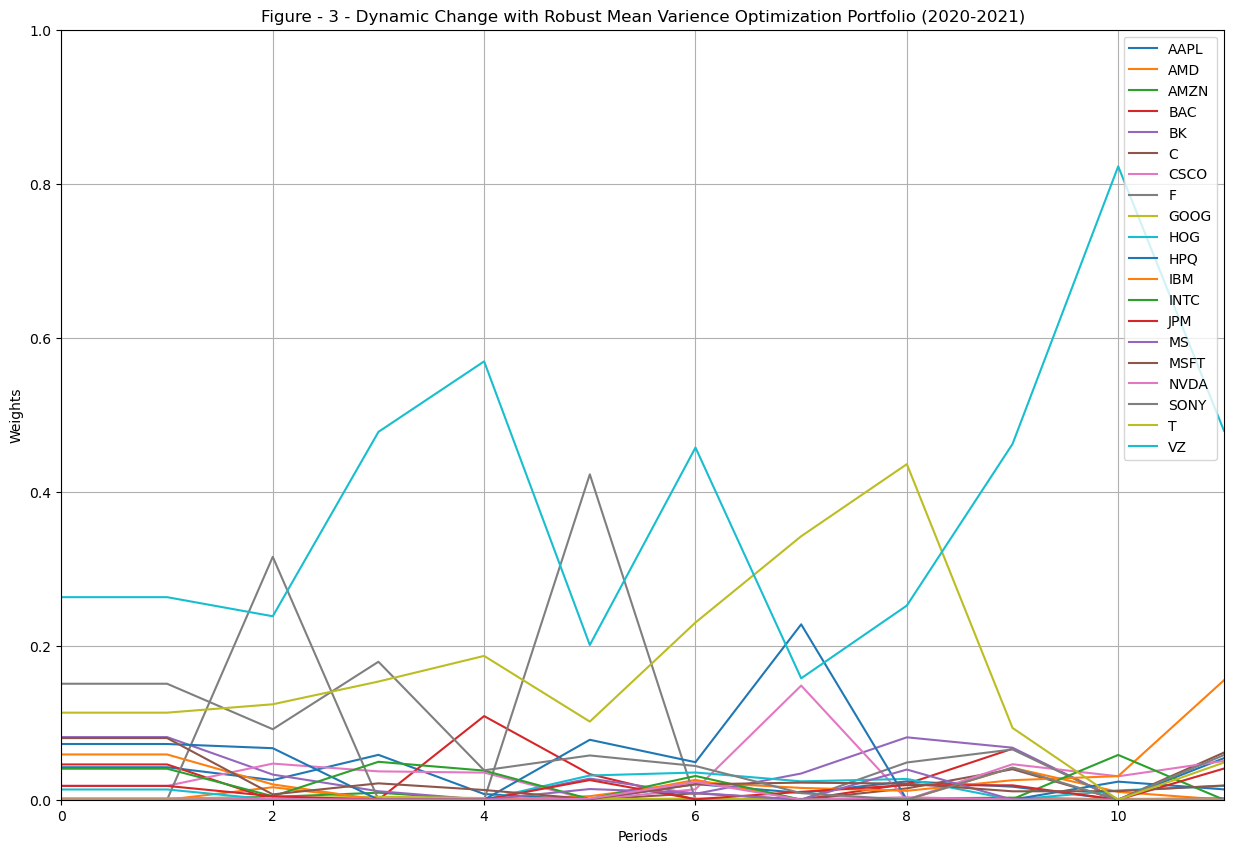

In [19]:
stock_name = df.columns[1:]
w_RMVO = []
x[6, period-1], cash[6, period-1] = fh_array[6](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, N_periods + 1):
    w_per_period = x[6, period - 1] / np.sum(x[6, period - 1])
    w_RMVO.append(w_per_period)

# Create DataFrame from the calculated weightings
df_RMVO = pd.DataFrame(np.array(w_RMVO), columns=stock_name)

# Plotting
plt.figure(figsize=(15, 10))
for col in df_RMVO.columns:
    plt.plot(df_RMVO.index, df_RMVO[col], label=col)
plt.title('Figure - 3 - Dynamic Change with Robust Mean Varience Optimization Portfolio (2020-2021)')
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.legend(loc='upper right')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xlim(0, 11)  # Set y-axis limits from 0 to 1
plt.grid(True)
plt.show()

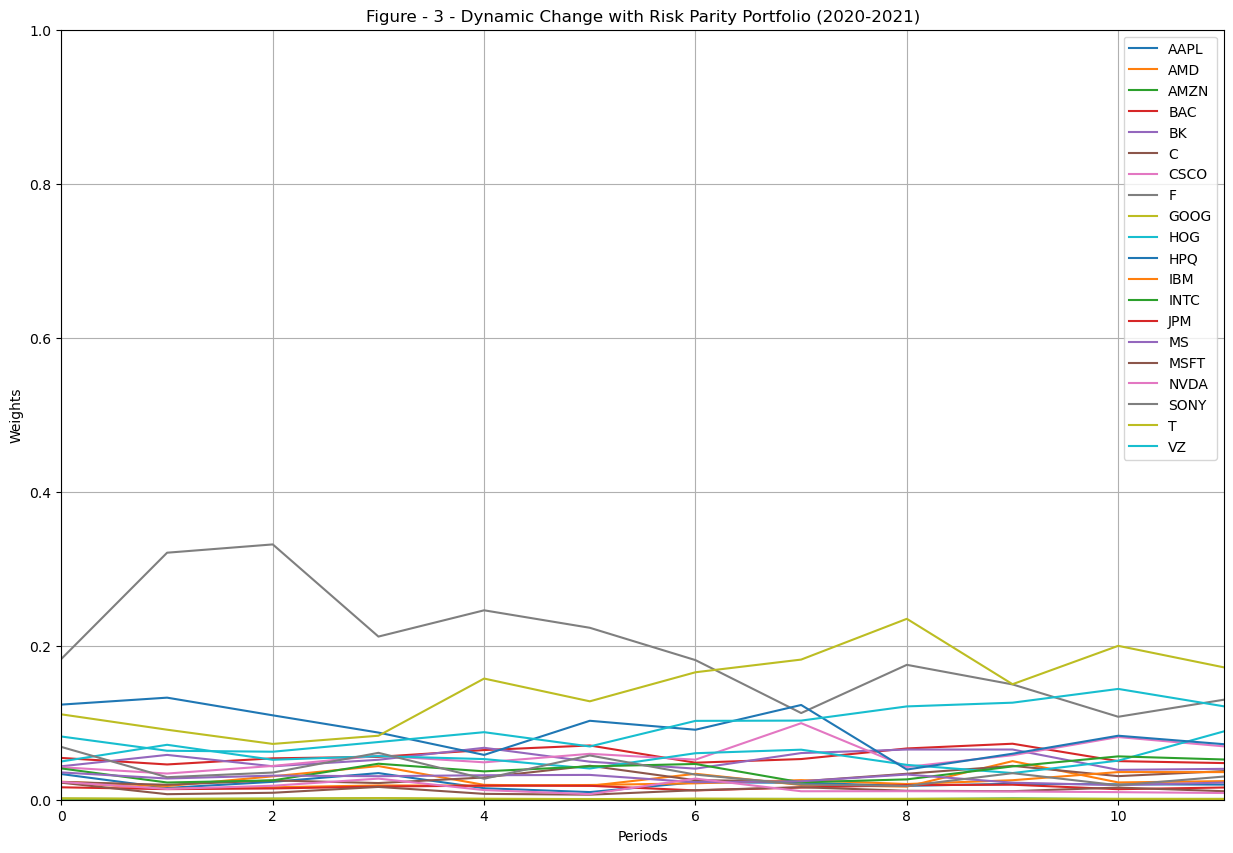

In [20]:
stock_name = df.columns[1:]
w_RMVO = []
x[6, period-1], cash[4, period-1] = fh_array[4](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, N_periods + 1):
    w_per_period = x[4, period - 1] / np.sum(x[4, period - 1])
    w_RMVO.append(w_per_period)

# Create DataFrame from the calculated weightings
df_RMVO = pd.DataFrame(np.array(w_RMVO), columns=stock_name)

# Plotting
plt.figure(figsize=(15, 10))
for col in df_RMVO.columns:
    plt.plot(df_RMVO.index, df_RMVO[col], label=col)
plt.title('Figure - 3 - Dynamic Change with Risk Parity Portfolio (2020-2021)')
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.legend(loc='upper right')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xlim(0, 11)  # Set y-axis limits from 0 to 1
plt.grid(True)
plt.show()

# FOR YEARS 2008 & 2009

In [21]:
# Input file
input_file_prices = 'Daily_closing_prices2008_2009.csv'

In [22]:
# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [23]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
#day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])   # for 2020-2021 csv

day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])   # for 2008-2009 csv
#day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])   # for 2022 csv

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)


# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf = 0.045


# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_max_Sharpe', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio' ]
#N_strat = 6 # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_max_Sharpe, strat_robust_optim]
#fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe,strat_equal_risk_contr, strat_robust_optim]


portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
interest = np.full((1,N_periods), init_value * (r_rf/6), dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period

   # Depending on what data/csv (i.e time period) uncomment code

   # example for 2008-2009 data
   if dates_array[0, 0] == 8:
       cur_year  = 8 + math.floor(period/7)
   else:
       cur_year  = 2008 + math.floor(period/7)    

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]


   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      if strategy == 6:
            return_check = np.dot(mu,w_erc)
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
      if strategy == 5:
        cash[strategy, period-1] = cash[strategy, period-1] - interest[0,period-1]

      
      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if cash[strategy, period-1] < 0:
        if strategy==5 and cash[5,0]<0:
            portfolio_value = (curr_cash + np.dot(cur_prices,curr_positions))*2
        else:
            portfolio_value = curr_cash + np.dot(cur_prices,curr_positions)
            
        weight = x[strategy, period-1]/sum(x[strategy, period-1])
        non_cash = weight * abs(cash[strategy, period-1])
        x[strategy, period-1] = x[strategy, period-1] - np.ceil(non_cash/cur_prices)
        tran_cost_1 = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
        
        if strategy==5:
            cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - tran_cost_1 - interest[0,period-1]
        else:
            cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - tran_cost_1
            
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      if strategy ==5:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
    
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 385097.33


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 385097.33, value end = $ 325918.43
  Strategy "Equally Weighted Portfolio", value begin = $ 381650.20, value end = $ 326932.01
  Strategy "Mininum Variance Portfolio", value begin = $ 383262.48, value end = $ 327141.19
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 381265.72, value end = $ 332652.78


C:\ProgramData\Anaconda3\lib\site-packages\cyipopt\utils.py:43: FutureWarning: The method named 'addOption' in class 'Problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)


  Strategy "Equal Risk Contributions Portfolio", value begin = $ 381845.09, value end = $ 329226.79
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 376476.20, value end = $ 279373.41
  Strategy "Robust Optimization Portfolio", value begin = $ 382119.96, value end = $ 324775.08

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 325807.12, value end = $ 349997.13
  Strategy "Equally Weighted Portfolio", value begin = $ 322099.54, value end = $ 354816.63
  Strategy "Mininum Variance Portfolio", value begin = $ 322716.04, value end = $ 365545.49
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 325785.96, value end = $ 344234.79
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 324432.64, value end = $ 361277.52
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 262782.97, value end = $ 299474.97
  Strategy "Robust Optimization Portfolio", value begin = $ 323203.69, value end = $ 3476

  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ -42196.56, value end = $ 3292.43
  Strategy "Robust Optimization Portfolio", value begin = $ 314356.35, value end = $ 351449.64


## Plot Results

### PLOT FOR DAILY VALUE OF PORTFOLIOS

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

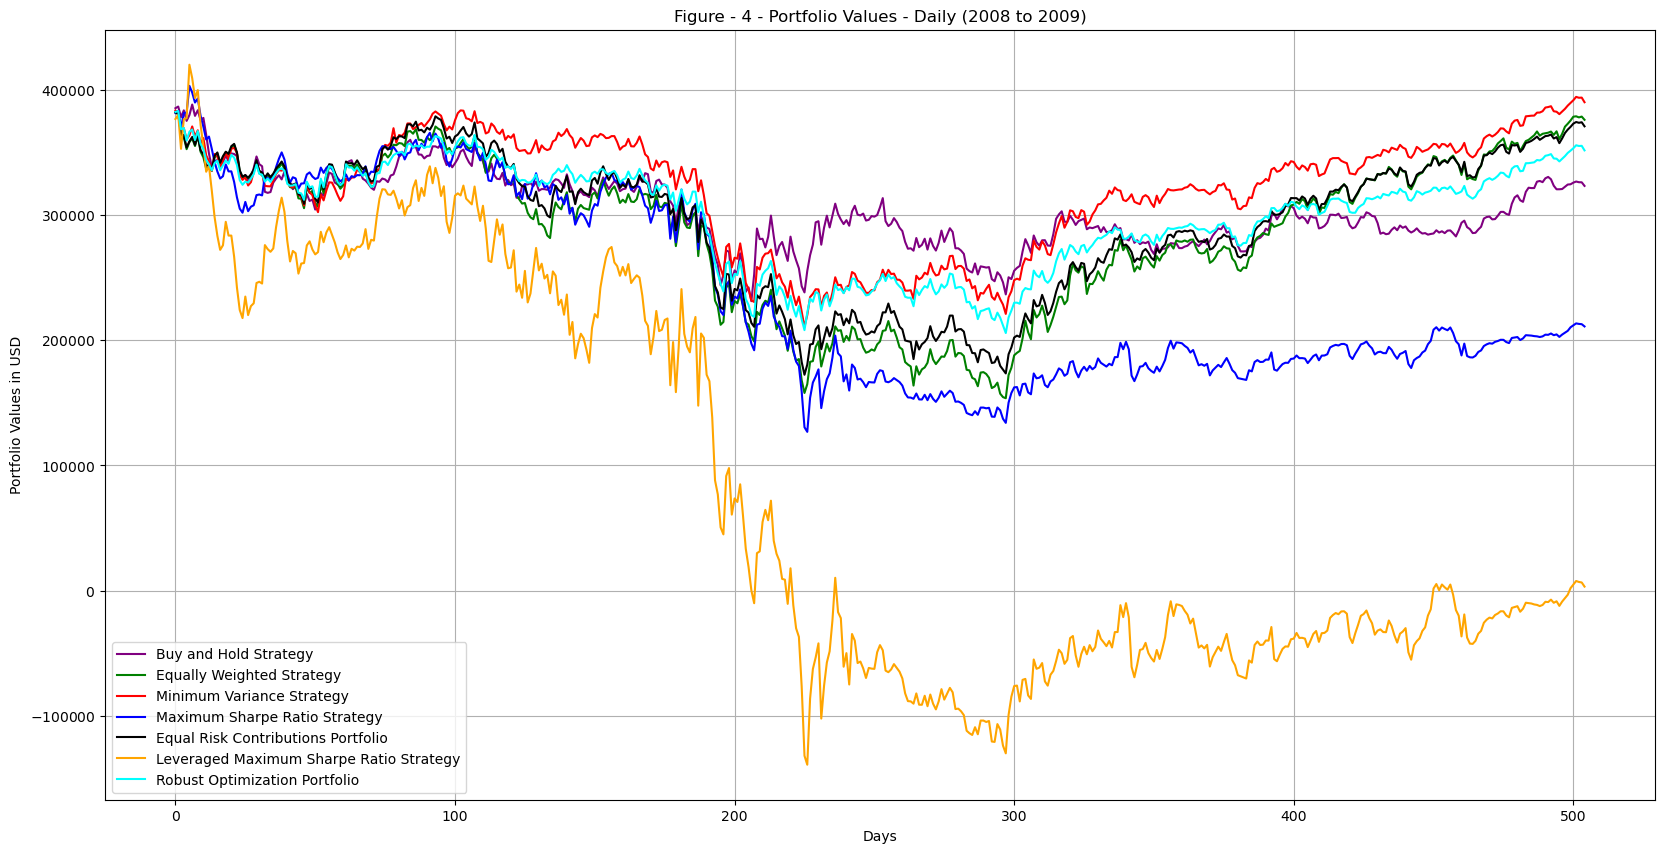

In [25]:
plt.figure(figsize=(20,10))
plt.plot(portf_value[0],label='Buy and Hold Strategy',color='purple')
plt.plot(portf_value[1],label='Equally Weighted Strategy',color='green')
plt.plot(portf_value[2],label='Minimum Variance Strategy',color='red')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio Strategy',color='blue')
plt.plot(portf_value[4],label='Equal Risk Contributions Portfolio',color='black')
plt.plot(portf_value[5],label='Leveraged Maximum Sharpe Ratio Strategy',color='orange')
plt.plot(portf_value[6],label='Robust Optimization Portfolio',color='cyan')
plt.legend()


formatter = ticker.ScalarFormatter(useMathText=True)
plt.gca().yaxis.set_major_formatter(formatter)
formatter.set_scientific(False)


plt.title('Figure - 4 - Portfolio Values - Daily (2008 to 2009)')
plt.xlabel('Days')
plt.ylabel('Portfolio Values in USD')
plt.grid(True)
plt.show()

### PLOT FOR MAXIMUM DRAWDOWN OF PORTFOLIO STRATEGIES

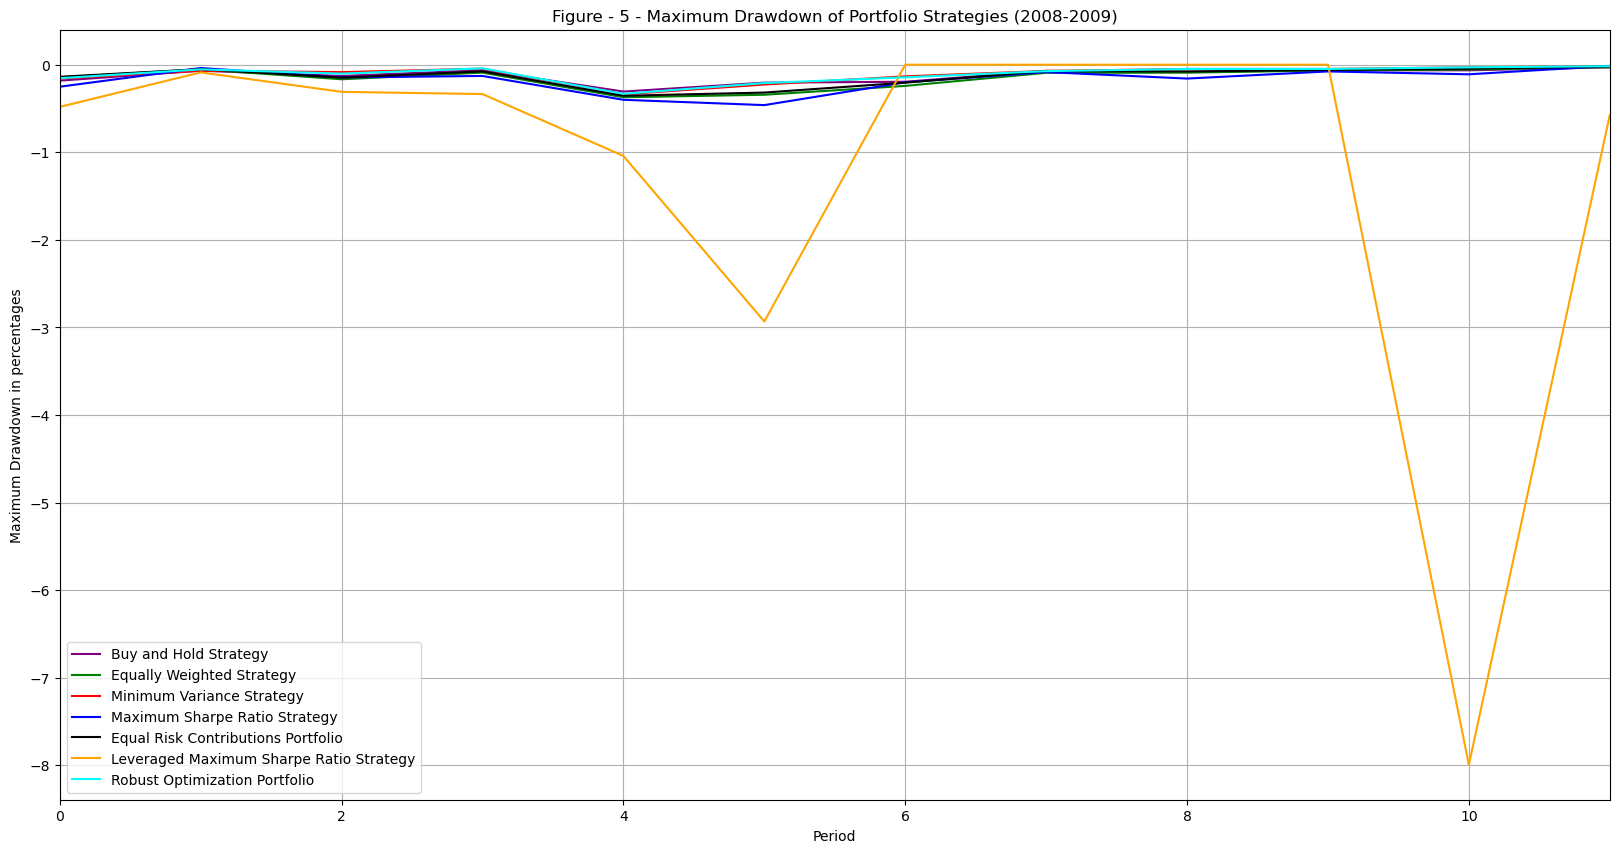

In [26]:
max_drawdowns_periods = []
for portf in portf_value:
    max_drawdowns = []
    for period in range(1, N_periods+1):
        if dates_array[0, 0] == 8:
            cur_year  = 8 + math.floor(period/7)
        else:
            cur_year  = 2008 + math.floor(period/7)    

        cur_month = 2*((period-1)%6) + 1
        day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
        day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
        period_portf = portf[day_ind_start:day_ind_end+1]
        if len(period_portf) > 0:
            rolling_max = np.maximum.accumulate(period_portf)
            drawdown = (period_portf - rolling_max) / rolling_max
            max_drawdowns.append(np.min(drawdown))
    max_drawdowns_periods.append(max_drawdowns)
# Plot maximum drawdown for each strategy
plt.figure(figsize=(20,10))
plt.plot(max_drawdowns_periods[0],label='Buy and Hold Strategy',color='purple')
plt.plot(max_drawdowns_periods[1],label='Equally Weighted Strategy',color='green')
plt.plot(max_drawdowns_periods[2],label='Minimum Variance Strategy',color='red')
plt.plot(max_drawdowns_periods[3],label='Maximum Sharpe Ratio Strategy',color='blue')
plt.plot(max_drawdowns_periods[4],label='Equal Risk Contributions Portfolio',color='black')
plt.plot(max_drawdowns_periods[5],label='Leveraged Maximum Sharpe Ratio Strategy',color='orange')
plt.plot(max_drawdowns_periods[6],label='Robust Optimization Portfolio',color='cyan')

plt.title('Figure - 5 - Maximum Drawdown of Portfolio Strategies (2008-2009)')
plt.xlabel('Period')
plt.ylabel('Maximum Drawdown in percentages')
plt.xlim(0, 11)  # Set y-axis limits from 0 to 1
plt.legend()
plt.grid(True)
plt.show()

### Dynamic Changes in Robust MVO Portfolio

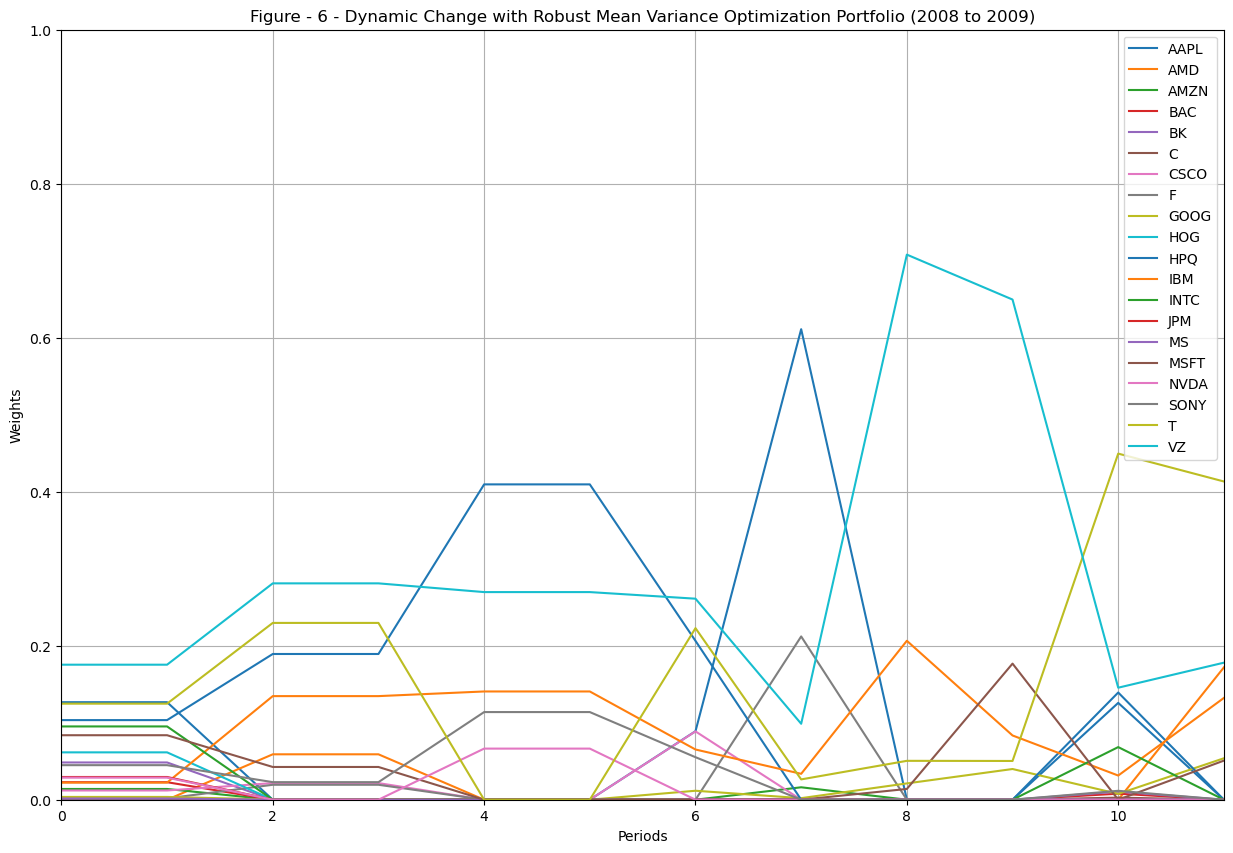

In [27]:
stock_name = df.columns[1:]
w_RMVO = []
x[6, period-1], cash[6, period-1] = fh_array[6](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, N_periods + 1):
    w_per_period = x[6, period - 1] / np.sum(x[6, period - 1])
    w_RMVO.append(w_per_period)

# Create DataFrame from the calculated weightings
df_RMVO = pd.DataFrame(np.array(w_RMVO), columns=stock_name)

# Plotting
plt.figure(figsize=(15, 10))
for col in df_RMVO.columns:
    plt.plot(df_RMVO.index, df_RMVO[col], label=col)
plt.title('Figure - 6 - Dynamic Change with Robust Mean Variance Optimization Portfolio (2008 to 2009)')
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.legend(loc='upper right')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xlim(0, 11)  # Set y-axis limits from 0 to 1
plt.grid(True)
plt.show()

### Dynamic Changes in Minimum Variance Portfolio

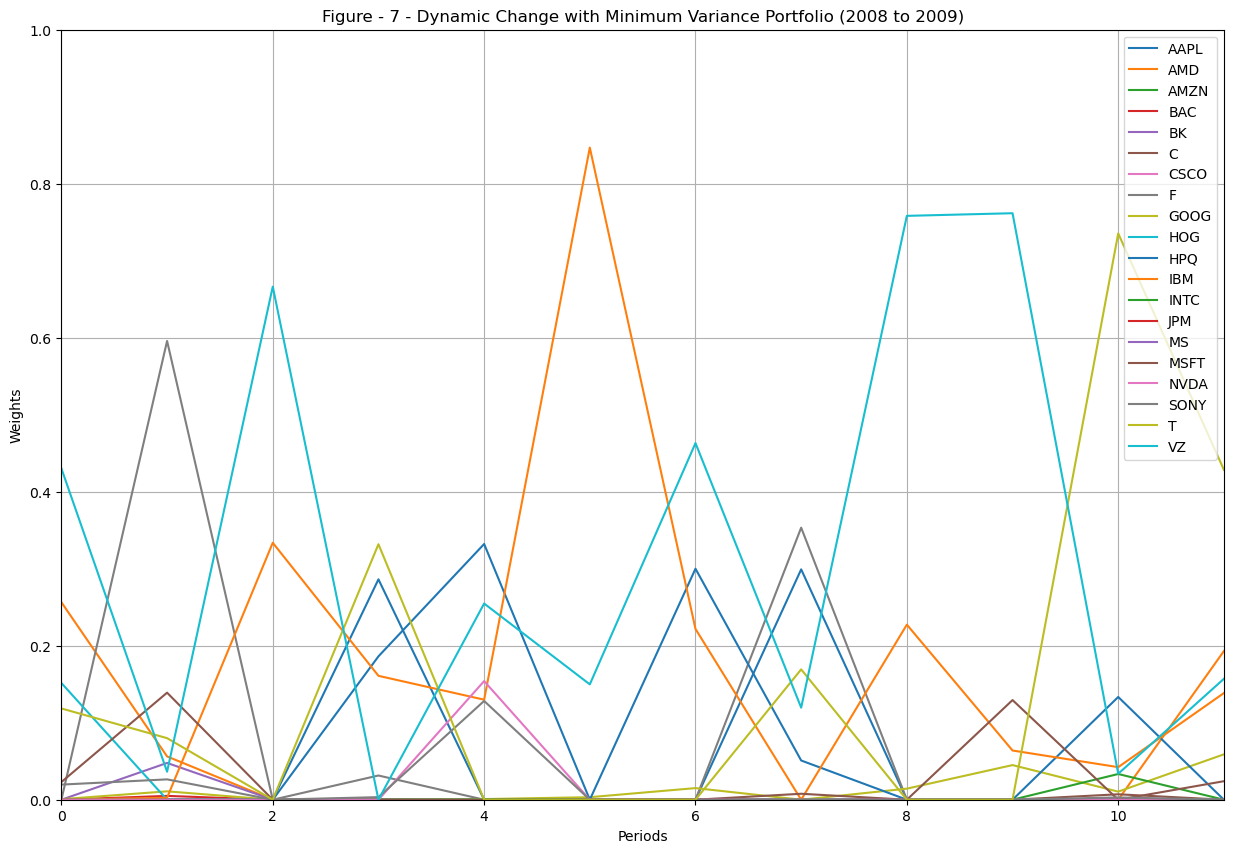

In [28]:
stock_name = df.columns[1:]
w_minVAR = []
x[2, period-1], cash[2, period-1] = fh_array[2](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, N_periods + 1):
    w_per_period = x[2, period - 1] / np.sum(x[2, period - 1])
    w_minVAR.append(w_per_period)

# Create DataFrame from the calculated weightings
df_minVAR = pd.DataFrame(np.array(w_minVAR), columns=stock_name)

# Plotting
plt.figure(figsize=(15, 10))
for col in df_minVAR.columns:
    plt.plot(df_minVAR.index, df_minVAR[col], label=col)
plt.title('Figure - 7 - Dynamic Change with Minimum Variance Portfolio (2008 to 2009)')
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.legend(loc='upper right')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xlim(0, 11)  # Set y-axis limits from 0 to 1
plt.grid(True)
plt.show()

### Dynamic Changes in Max Sharpe Ratio Portfolio

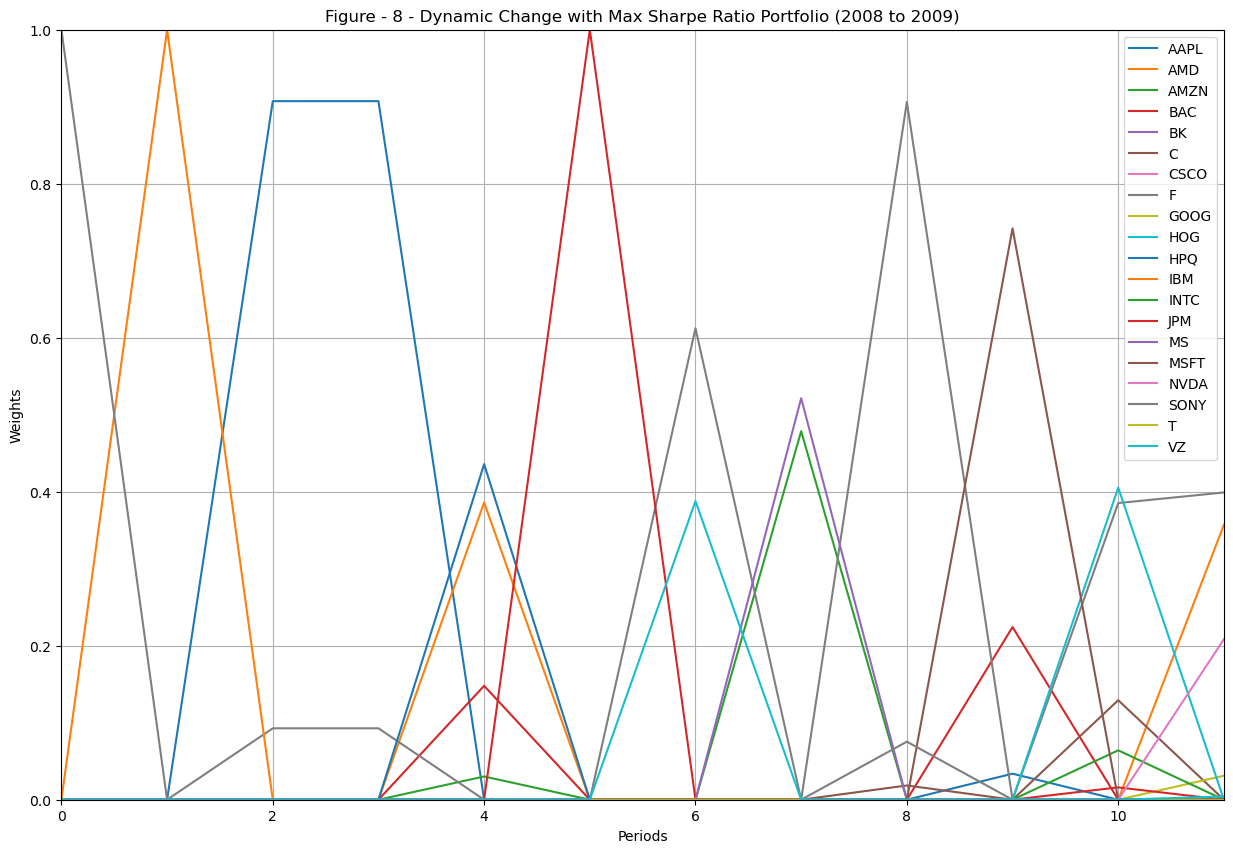

In [29]:
stock_name = df.columns[1:]
w_maxsharp = []
x[3, period-1], cash[3, period-1] = fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, N_periods + 1):
    w_per_period = x[3, period - 1] / np.sum(x[3, period - 1])
    w_maxsharp.append(w_per_period)

# Create DataFrame from the calculated weightings
df_maxsharp = pd.DataFrame(np.array(w_maxsharp), columns=stock_name)

# Plotting
plt.figure(figsize=(15, 10))
for col in df_maxsharp.columns:
    plt.plot(df_maxsharp.index, df_maxsharp[col], label=col)
plt.title('Figure - 8 - Dynamic Change with Max Sharpe Ratio Portfolio (2008 to 2009)')
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.legend(loc='upper right')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xlim(0, 11)  # Set y-axis limits from 0 to 1
plt.grid(True)
plt.show()

# FOR THE YEAR 2022

In [30]:
# Input file
input_file_prices = 'Daily_closing_prices2022.csv'

In [31]:
# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [32]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
#day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])   # for 2020-2021 csv

#day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])   # for 2008-2009 csv
day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])   # for 2022 csv

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)


# Annual risk-free rate for year 2022 is 3.75%
r_rf = 0.0375

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_max_Sharpe', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio' ]
#N_strat = 6 # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_max_Sharpe, strat_robust_optim]
#fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe,strat_equal_risk_contr, strat_robust_optim]


portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
interest = np.full((1,N_periods), init_value * (r_rf/6), dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   # Depending on what data/csv (i.e time period) uncomment code
   if dates_array[0, 0] == 22:
       cur_year  = 22 + math.floor(period/7)
   else:
       cur_year  = 2022 + math.floor(period/7)

   # example for 2008-2009 data
   #if dates_array[0, 0] == 8:
   #    cur_year  = 8 + math.floor(period/7)
   #else:
   #    cur_year  = 2008 + math.floor(period/7)    

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]


   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
      if strategy == 5:
        cash[strategy, period-1] = cash[strategy, period-1] - interest[0,period-1]

      
      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if cash[strategy, period-1] < 0:
        if strategy==5 and cash[5,0]<0:
            portfolio_value = (curr_cash + np.dot(cur_prices,curr_positions))*2
        else:
            portfolio_value = curr_cash + np.dot(cur_prices,curr_positions)
            
        weight = x[strategy, period-1]/sum(x[strategy, period-1])
        non_cash = weight * abs(cash[strategy, period-1])
        x[strategy, period-1] = x[strategy, period-1] - np.ceil(non_cash/cur_prices)
        tran_cost_1 = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
        
        if strategy==5:
            cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - tran_cost_1 - interest[0,period-1]
        else:
            cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - tran_cost_1
            
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      if strategy ==5:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
    
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 890077.15


Period 1: start date 01/03/2022, end date 02/28/2022
  Strategy "Buy and Hold", value begin = $ 890077.15, value end = $ 924072.93
  Strategy "Equally Weighted Portfolio", value begin = $ 881997.57, value end = $ 802549.65
  Strategy "Mininum Variance Portfolio", value begin = $ 885873.66, value end = $ 863328.94
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 881222.74, value end = $ 800309.12


C:\ProgramData\Anaconda3\lib\site-packages\cyipopt\utils.py:43: FutureWarning: The method named 'addOption' in class 'Problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)


  Strategy "Equal Risk Contributions Portfolio", value begin = $ 882841.49, value end = $ 819877.55
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 871258.68, value end = $ 709486.34
  Strategy "Robust Optimization Portfolio", value begin = $ 883675.91, value end = $ 828053.68

Period 2: start date 03/01/2022, end date 04/29/2022
  Strategy "Buy and Hold", value begin = $ 921940.14, value end = $ 807230.89
  Strategy "Equally Weighted Portfolio", value begin = $ 783067.12, value end = $ 705796.90
  Strategy "Mininum Variance Portfolio", value begin = $ 854828.72, value end = $ 782907.97
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 783852.04, value end = $ 694344.92
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 804192.79, value end = $ 742881.97
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 671049.51, value end = $ 492775.90
  Strategy "Robust Optimization Portfolio", value begin = $ 819303.00, value end = $ 7584

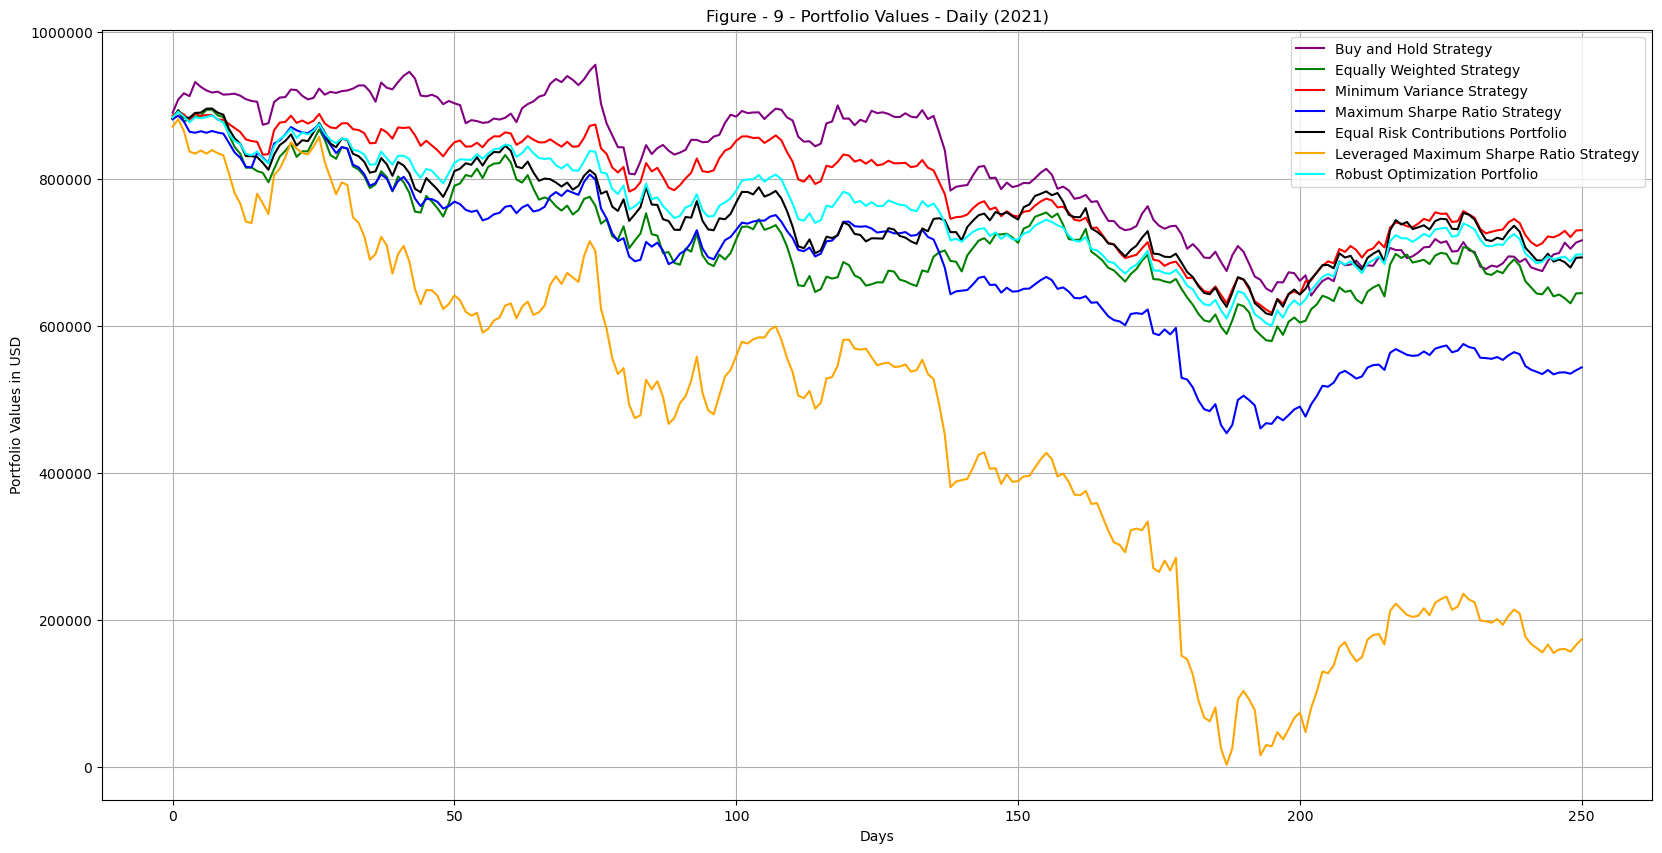

In [33]:
plt.figure(figsize=(20,10))
plt.plot(portf_value[0],label='Buy and Hold Strategy',color='purple')
plt.plot(portf_value[1],label='Equally Weighted Strategy',color='green')
plt.plot(portf_value[2],label='Minimum Variance Strategy',color='red')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio Strategy',color='blue')
plt.plot(portf_value[4],label='Equal Risk Contributions Portfolio',color='black')
plt.plot(portf_value[5],label='Leveraged Maximum Sharpe Ratio Strategy',color='orange')
plt.plot(portf_value[6],label='Robust Optimization Portfolio',color='cyan')
plt.legend()


formatter = ticker.ScalarFormatter(useMathText=True)
plt.gca().yaxis.set_major_formatter(formatter)
formatter.set_scientific(False)


plt.title('Figure - 9 - Portfolio Values - Daily (2021)')
plt.xlabel('Days')
plt.ylabel('Portfolio Values in USD')
plt.grid(True)
plt.show()

### PLOT FOR MAXIMUM DRAWDOWN OF PORTFOLIO STRATEGIES

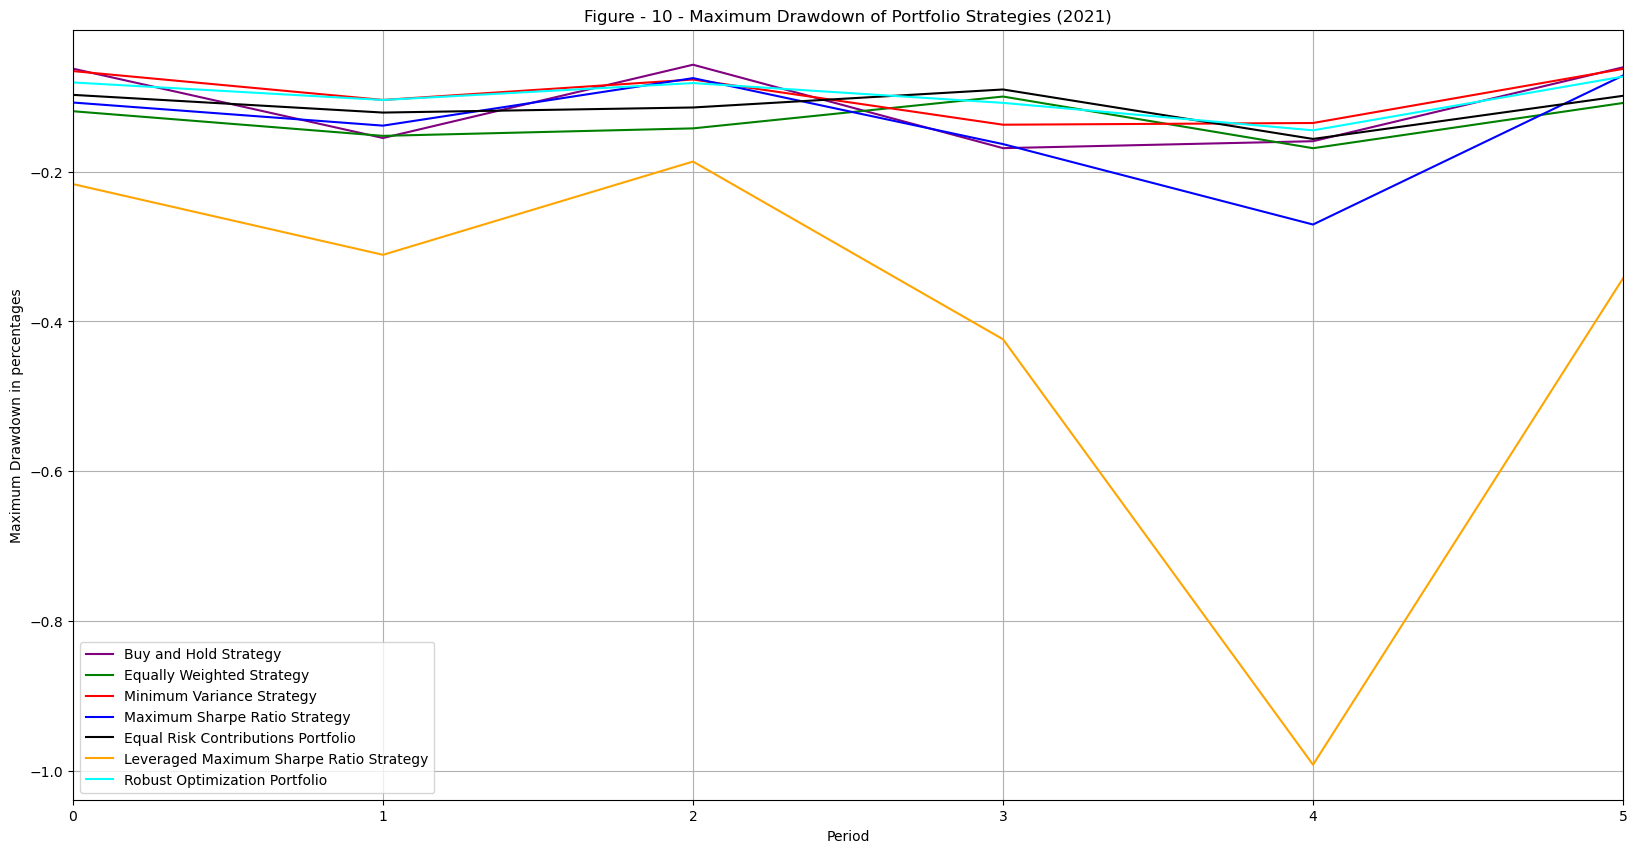

In [34]:
max_drawdowns_periods = []
for portf in portf_value:
    max_drawdowns = []
    for period in range(1, N_periods+1):
        if dates_array[0, 0] == 22:
            cur_year  = 22 + math.floor(period/7)
        else:
            cur_year  = 2022 + math.floor(period/7)    

        cur_month = 2*((period-1)%6) + 1
        day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
        day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
        #period_portf = [portf[day_ind_start], portf[day_ind_end]]
        period_portf = portf[day_ind_start:day_ind_end+1]
        if len(period_portf) > 0:
            rolling_max = np.maximum.accumulate(period_portf)
            drawdown = (period_portf - rolling_max) / rolling_max
            max_drawdowns.append(np.min(drawdown))
    max_drawdowns_periods.append(max_drawdowns)
# Plot maximum drawdown for each strategy
plt.figure(figsize=(20,10))
plt.plot(max_drawdowns_periods[0],label='Buy and Hold Strategy',color='purple')
plt.plot(max_drawdowns_periods[1],label='Equally Weighted Strategy',color='green')
plt.plot(max_drawdowns_periods[2],label='Minimum Variance Strategy',color='red')
plt.plot(max_drawdowns_periods[3],label='Maximum Sharpe Ratio Strategy',color='blue')
plt.plot(max_drawdowns_periods[4],label='Equal Risk Contributions Portfolio',color='black')
plt.plot(max_drawdowns_periods[5],label='Leveraged Maximum Sharpe Ratio Strategy',color='orange')
plt.plot(max_drawdowns_periods[6],label='Robust Optimization Portfolio',color='cyan')

plt.title('Figure - 10 - Maximum Drawdown of Portfolio Strategies (2021)')
plt.xlabel('Period')
plt.ylabel('Maximum Drawdown in percentages')
plt.xlim(0, 5)  # Set y-axis limits from 0 to 1
plt.legend()
plt.grid(True)
plt.show()